In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import transformers
import torch
from transformers import pipeline
import string
from transformers import BertTokenizer, BertForMaskedLM

from valuemap.models import Model, MultiModel
from valuemap.values import ValueMap, ValueSearch

In [2]:
def load_dataset():
    # Load the dataset into separate DataFrames for each split
    df_training = pd.read_csv('arguments-training.tsv', delimiter='\t')
    df_validation = pd.read_csv('arguments-validation.tsv', delimiter='\t')
    df_test = pd.read_csv('arguments-test.tsv', delimiter='\t')

    # Concatenate all the dataframes
    df = pd.concat([df_training, df_validation, df_test])

    # Extract the argument text from each DataFrame
    arguments = df['Premise'].tolist()
    stances = df['Stance'].tolist()
    conclusions = df['Conclusion'].tolist()

    return arguments, stances, conclusions

In [3]:
def process_sentences(sentences):
    processed = []
    for sentence in sentences:
        # Remove punctuation
        sentence = sentence.translate(str.maketrans('', '', string.punctuation))
        # Convert to lowercase
        sentence = sentence.lower()
        processed.append(sentence)
    return processed

In [4]:
# model inizialization
model_bert = pipeline('fill-mask', model='bert-base-uncased') # Bert

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'bert.pooler.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
# model inizialization for adjectiveList-based approach
def load_model() :
    # Load the model and tokenizer
    model = BertForMaskedLM.from_pretrained('bert-base-uncased')
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    return model, tokenizer

model, tokenizer = load_model()[0], load_model()[1]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'bert.pooler.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'bert.pooler.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model t

In [6]:
# Load dataset
arguments, stances, conclusions = load_dataset()

# Preprocess premise and conclusion
arguments = process_sentences(arguments)
conclusions = process_sentences(conclusions)

In [7]:
# Map each argument to the corresponding stance and conclusion
if len(arguments) != len(stances) or len(arguments) != len(conclusions):
    print("Error: incompatible data")
else:
    input = {}
    for i in range(len(arguments)):
        input[arguments[i]] = (stances[i], conclusions[i])

In [29]:
def radial_plot(results):
    # Create a list of adjectives and their probabilities
    adjectives = list(results.keys())
    probabilities = list(results.values())

    # Compute angle for each adjective
    angles = np.linspace(0, 2 * np.pi, len(adjectives), endpoint=False).tolist()

    # The figure is plotted in a polar projection
    fig, ax = plt.subplots(figsize=(3, 3), subplot_kw=dict(polar=True))
    
    # Plot each line separately
    for i in range(len(adjectives)):
        ax.plot([angles[i], angles[i]], [0, probabilities[i]], color='blue')
    
    # Fill the area under the curve
    ax.fill(angles, probabilities, 'blue', alpha=0.1)
    
    # Set the yticks to be empty and xticks to be the adjectives
    ax.set_yticklabels([])
    ax.set_xticks(angles)
    ax.set_xticklabels(adjectives)
    
    # Display the plot
    plt.show()

In [30]:
import random

# Random argument selection
input_argument = random.choice(list(input.keys()))

argument = input_argument
stance = input[input_argument][0]
conclusion = input[input_argument][1]

In [31]:
def generate_word(model):
    # Initialize an empty list to store the results
    results = []

    # Create prompt 
    prompt = f"i am {stance} the fact that {conclusion} because i think that {argument}. i am a {model.tokenizer.mask_token}."
    
    # Generate the filling
    output = model(prompt)
   
    # Sort output by 'score'
    output.sort(key=lambda x: x['score'], reverse=True)
    
    # Create a dictionary of other predicted words with their scores
    predictions = {result['token_str']: result['score'] for result in output}

    # Extract 'sequence' with higher 'score'
    description = output[0]['sequence']
    
    return predictions, description

In [32]:
generate_word(model_bert)

({'feminist': 0.5839113593101501,
  'conservative': 0.08859874308109283,
  'vegetarian': 0.03811376541852951,
  'libertarian': 0.03168429806828499,
  'liberal': 0.031209023669362068},
 'i am in favor of the fact that we should legalize polygamy because i think that polygamy is an ancient practice and its legalization can bring social justice for all involved. i am a feminist.')

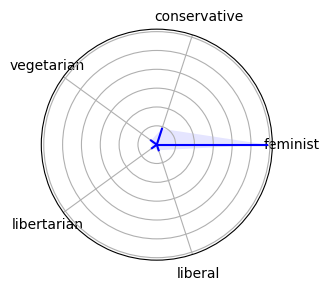

In [33]:
radial_plot(generate_word(model_bert)[0])

In [44]:
adjective_list_ordered = [ 
    "conservative",
    "republican",
    "capitalist",
    "libertarian",
    "centrist",
    "democrat",
    "liberal",
    "progressive",
    "socialist",
    "communist",
    "anarchist",
]

In [45]:
def generate_word_adj(model, tokenizer, adjective_list):
    # Create prompt 
    prompt = f"i am {stance} the fact that {conclusion} because i think that {argument}. i am a {tokenizer.mask_token}."
    # Initialize a dictionary to store the probabilities
    probabilities = {}
    # For each word in the list, generate a score
    for word in adjective_list:
        # Replace the mask token with the word
        new_prompt = prompt.replace(tokenizer.mask_token, word)
        # Encode the new prompt
        inputs = tokenizer.encode_plus(new_prompt, return_tensors='pt')
        # Generate the filling
        outputs = model(**inputs)
        logits = outputs.logits
        # Calculate the softmax probabilities from logits
        softmax_probs = torch.nn.functional.softmax(logits, dim=-1)
        # Get the probability of the word
        word_id = tokenizer.encode(word, add_special_tokens=False)[0]
        word_prob = softmax_probs[0, -1, word_id].item()

        # Store the probability of the word
        probabilities[word] = word_prob

    # Sort the probabilities dictionary by value in descending order
    sorted_probabilities = {k: v for k, v in sorted(probabilities.items(), key=lambda item: item[1], reverse=True)}

    # Choose the word with the highest probability
    top_word = next(iter(sorted_probabilities))

    # Replace the mask token in the original prompt with the top word
    description = prompt.replace(tokenizer.mask_token, top_word)

    return sorted_probabilities, description

In [46]:
generate_word_adj(model, tokenizer, adjective_list)

({'republican': 5.990141858092102e-07,
  'liberal': 1.0206345280039386e-07,
  'communist': 6.006472119679529e-08,
  'democrat': 4.501180228544399e-08,
  'socialist': 2.699546364226535e-08,
  'conservative': 2.0554972834929686e-08,
  'capitalist': 1.4312433016527848e-08,
  'libertarian': 1.963863294207613e-09,
  'progressive': 1.69067249089494e-09,
  'anarchist': 4.824980970319359e-10,
  'centrist': 1.3937495602078798e-10},
 'i am in favor of the fact that we should legalize polygamy because i think that polygamy is an ancient practice and its legalization can bring social justice for all involved. i am a republican.')

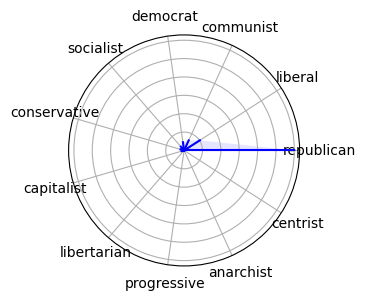

In [47]:
radial_plot(generate_word_adj(model, tokenizer, adjective_list)[0])